In [1]:
#%pip install
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 instalsklearn
#!pip3 install joblib --upgrade
#!pip3 install fsspec
#!pip3 install s3fs 
#!pip3 install jmespath --upgrade
#!python3 -m jmespath install
#!pip3 install jmespath==0.9.4
#!conda install -c conda-forge jmespath

In [2]:
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis
from sklearn.covariance import LedoitWolf
import os

In [3]:
df1=pd.read_csv('s3://proyecto-integrador/raw/DTF/DTF.csv', header=0)
df1=df1.drop([0])
df1=df1.iloc[:-4,:]
df1.iloc[:,0]=pd.to_datetime(df1.iloc[:,0])
#df1=df1.loc[np.logical_and(df1.iloc[:,0].dt.weekday!=5,df1.iloc[:,0].dt.weekday!=6)]
df1.set_index('Fecha', inplace=True)
df1.shape

(10358, 49)

In [4]:
df2=pd.read_csv('s3://proyecto-integrador/raw/TRM/TMR.csv', header=0)
df2=df2.drop([0])
df2=df2.iloc[:-4,:]
df2.iloc[:,0]=pd.to_datetime(df2.iloc[:,0])
#df2=df2.loc[np.logical_and(df2.iloc[:,0].dt.weekday!=5,df2.iloc[:,0].dt.weekday!=6)]
df2.set_index('Fecha', inplace=True)
df2.shape

(2503, 92)

In [5]:
dfs = pd.merge(df2,df1,on='Fecha',how='outer')
dfs=dfs.sort_index(axis=0)

In [6]:
dfs

,Tasa Representativa del Mercado (TRM),Indicador Bancario de Referencia (IBR) overnight efectiva,Indicador Bancario de Referencia (IBR) overnight nominal,Indicador Bancario de Referencia (IBR) a 1 mes efectiva,Indicador Bancario de Referencia (IBR) a 1 mes nominal,Indicador Bancario de Referencia (IBR) a 3 meses efectiva,Indicador Bancario de Referencia (IBR) a 3 meses nominal,Tasa interbancaria (TIB),Cuenta corriente porcentaje del PIB anual,Cuenta corriente porcentaje del PIB trimestral,...,M3 semanal_y,M3 mensual_y,Importaciones totales (Bienes) Balanza de pagos_y,Exportaciones totales (Bienes) Balanza de pagos_y,Remesas de trabajadores mensual_y,Cuenta Financiera balanza de pagos_y,Cuasidineros - cuentas de ahorro mensual_y,Cuasidineros - cuentas de ahorro semanal_y,Depósitos en el sistema financiero cuentas corrientes total semanal_y,Depósitos en el sistema financiero cuentas corrientes total mensual_y
Fecha,,,,,,,,,,,,,,,,,,,,,
1982-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,682.033,NaN,NaN,NaN,NaN,NaN,NaN,162.557,177.665,NaN
1982-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,681.198,NaN,NaN,NaN,NaN,NaN,NaN,164.910,177.432,NaN
1982-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,691.154,NaN,NaN,NaN,NaN,NaN,NaN,165.570,179.963,NaN
1982-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,693.017,NaN,NaN,NaN,NaN,NaN,NaN,166.460,177.136,NaN
1982-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,698.448,NaN,NaN,NaN,NaN,NaN,NaN,169.447,178.466,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-04,3837.84,2.523,2.458,2.531,2.468,2.890,2.820,2.547928,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-05,3847.40,2.516,2.451,2.526,2.463,2.947,2.875,2.545138,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-06,3881.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


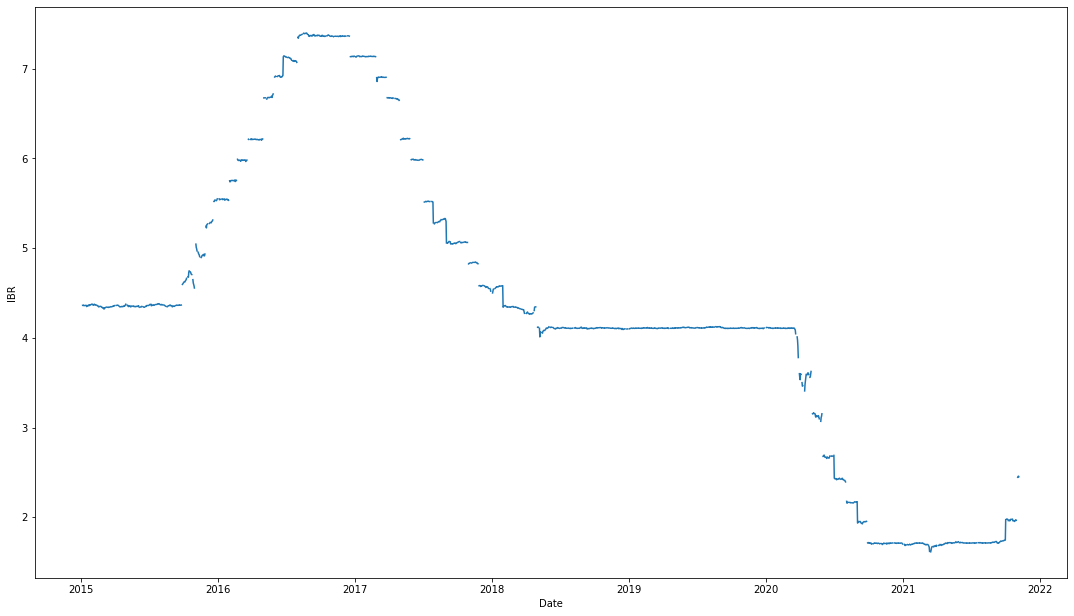

In [7]:
from matplotlib.pyplot import figure
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(dfs.loc[:,['Indicador Bancario de Referencia (IBR) overnight nominal']])
plt.xlabel("Date")
plt.ylabel("IBR")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

In [8]:
def ArregloInfo(df):
  df=df.sort_index(axis=0)
  df.loc[:,['Indicador Bancario de Referencia (IBR) overnight nominal']]=df.loc[:,['Indicador Bancario de Referencia (IBR) overnight nominal']].fillna(0)
  DataOk=np.where(np.array(df['Indicador Bancario de Referencia (IBR) overnight nominal'])!=0)
  df.iloc[0,:]=df.iloc[0,:].fillna(0)
  df=df.fillna(method='ffill')
  df = df.iloc[DataOk]


  dfFinal = df.copy()
  IBR_previo = []
  IBR_previo.append(0)
  for i in range(1,len(df)):
      dfFinal.iloc[i,:]=(df.iloc[i,:]/df.iloc[i-1,:])-1
      dfFinal.iloc[i-1,int(np.where(df.columns=='Indicador Bancario de Referencia (IBR) overnight nominal')[0])]=(df.iloc[i,int(np.where(dfs.columns=='Indicador Bancario de Referencia (IBR) overnight nominal')[0])]/df.iloc[i-1,int(np.where(df.columns=='Indicador Bancario de Referencia (IBR) overnight nominal')[0])])-1
      IBR_previo.append ((df.iloc[i,int(np.where(dfs.columns=='Indicador Bancario de Referencia (IBR) overnight nominal')[0])]/df.iloc[i-1,int(np.where(dfs.columns=='Indicador Bancario de Referencia (IBR) overnight nominal')[0])])-1)  
      
  dfFinal['Rendimiento IBR periodo previo'] = IBR_previo
  dfFinal=dfFinal.iloc[1:-1,:]
  dfFinal.replace([np.inf, -np.inf], np.nan, inplace=True)
  dfFinal=dfFinal.fillna(0)
  return dfFinal

In [9]:
df=ArregloInfo(dfs)
df.shape

(1667, 142)

In [10]:
count_nan_in_df = df.isnull().sum().sum()
print ('Count of NaN: ' + str(count_nan_in_df))

rows_with_nan = [index for index, row in df.iterrows() if row.isnull().any()]
rows_with_nan

Count of NaN: 0


[]

In [11]:
ToDrop = np.where(np.sum(np.array(df),axis=0)==0)[0]
ToDrop
df_revisado = df.drop(df.columns[ToDrop],axis=1)

In [12]:
ToDrop

array([18, 19, 33])

In [13]:
np.sum(np.array(df_revisado),axis=0)==0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [14]:
df_revisado.shape

(1667, 139)

In [15]:
df_revisado.to_csv('s3://proyecto-integrador/trusted/IBR_Input_Data.csv')